Data transforms that are required to transform ground truth bounding box annotations to tensors useful for training

In [1]:
import os
import torch
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2
from PIL import Image, ImageDraw, ImageFont

from torch import nn
from typing import List, Tuple

from torchvision.models import get_model
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNeXt50_32X4D_Weights
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import LastLevelP6P7

from torchvision.ops import Conv2dNormActivation
from functools import partial

import itertools


from torchvision import tv_tensors
from torchvision.transforms import v2
from typing import Any, Dict
from torchvision.transforms.v2._utils import _get_fill
from torchvision.ops import box_iou, box_convert


from yolo.visualize import render_bounding_boxes, plot
from yolo.model import YoloFPN
from yolo.data import CocoDataset, get_val_transforms

from collections import Counter

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
class Collate:
    def __call__(self, image_target_pair_list):
        
        batch_list = []
        for image, target in image_target_pair_list:
            batch_list.append({
                "image": image,
                "image_id": target["image_id"],
            })
        batch = torch.utils.data.default_collate(batch_list)
    
        batch["boxes"] = [x[1]["boxes"] for x in image_target_pair_list]
        batch["labels"] = [x[1]["labels"] for x in image_target_pair_list]
        return batch
    

IMAGE_SIZE = 608
val_dataset = CocoDataset(
    dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017",
    split = "validation",
    transform = get_val_transforms(resize_size=IMAGE_SIZE)
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0,
    collate_fn=Collate(),
)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


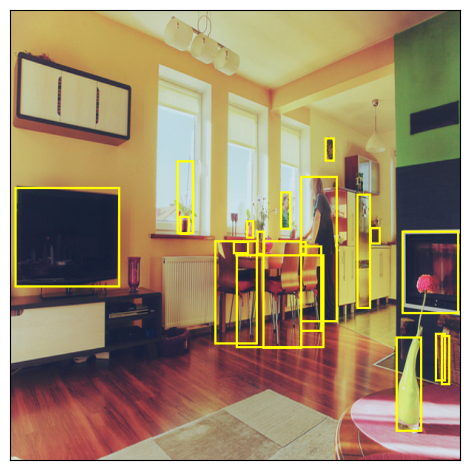

In [4]:
data = val_dataset[0]
plot([data])

In [5]:
################################
# Create a Lx4 anchor box grid
# where for an inupt image of size (416,608)
# and feature pyramids downsampling by factors x8, x16, x32 to (52,76), (26,38), (13,19)
# then L = 52*76*3 + 26*38*3 + 13*19*3
###############################

def make_spatial_anchors_per_scale(anchors_list: List[Tuple[int,int]], scale: int, image_height: int, image_width: int, verbose=False):
    """
    Create a Lx4 anchor box grid where for an input image of size (416,608)
    and feature pyramids downsampling by factors x8, x16, x32 to (52,76), (26,38), (13,19)
    then L = 52*76*3 + 26*38*3 + 13*19*3
    Need the anchor boxes to be in the original image resolution
    """
    
    num_anchors = len(anchors_list)
    anchor_halfs = torch.tensor(anchors_list, dtype=torch.float) / 2 # w/2, h/2

    x_axis = torch.arange(0, image_width, scale)
    y_axis = torch.arange(0, image_height, scale)
    grid_y, grid_x = torch.meshgrid(y_axis, x_axis, indexing="ij") # .shape [13,19]
    grid_xy = torch.stack([grid_x, grid_y], dim=-1) # .shape [13, 19, 2]
    grid_xy_centers = grid_xy + 0.5 * scale # center the anchor boxes in each grid cell

    # Expand grid_centers and anchors to enable broadcasting
    grid_centers_expanded = grid_xy_centers.unsqueeze(-2)  # Shape: (13, 19, 1, 2)
    anchor_halfs_expanded = anchor_halfs.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 2)
    # Compute the upper-left xy and lower-right xy coordinates in a vectorized manner
    # to get 2x tensors of shape (13,19,3,2), then concatenated to (13,19,3,4)
    grid_anchors_xyxy = torch.cat([grid_centers_expanded - anchor_halfs_expanded, grid_centers_expanded + anchor_halfs_expanded], axis=-1)
    grid_anchors_xyxy_flatten = grid_anchors_xyxy.flatten(end_dim=-2) # .shape (13*19*3, 4)
    
    if verbose:
        print(f"[make_spatial_anchors][scale: /{scale}] image resized from ({image_height}, {image_width}) to ({image_height / scale}, {image_width / scale})")
        s1,s2,s3 = grid_anchors_xyxy.shape[:3]
        print(f"[make_spatial_anchors][scale: /{scale}] L={s1}x{s2}x{s3}={s1*s2*s3} spatial_anchors is (L,4)={tuple(grid_anchors_xyxy_flatten.shape)}")
    return grid_anchors_xyxy_flatten


def make_spatial_anchors(anchors_list: List[Tuple[int,int]], scales: List[int], image_height: int, image_width: int, num_anchors_per_scale: int = 3, verbose: bool=False):
    anchors_per_scale = list(itertools.batched(anchors_list, num_anchors_per_scale))
    spatial_anchors_per_scale = [make_spatial_anchors_per_scale(anchors, scale, image_height, image_width, verbose = verbose) for anchors, scale in zip(anchors_per_scale, scales)]
    spatial_anchors = torch.cat(spatial_anchors_per_scale, axis=0)
    return spatial_anchors


def make_scale_map(scales: List[int], image_height: int, image_width: int, num_anchors_per_scale: int = 3):
    # scale at each position (L,)
    return torch.cat([torch.full((int(image_height * image_width*num_anchors_per_scale / scale**2), ), scale) for scale in scales])

def make_anchor_map(anchors_list: List[Tuple[int,int]], scales: List[int], image_height: int, image_width: int, num_anchors_per_scale: int = 3):
    anchors_per_scale = list(itertools.batched(anchors_list, num_anchors_per_scale))
    anchors_maps = []
    for anchors, scale in zip(anchors_per_scale, scales):
        anchors = torch.tensor(anchors, dtype=torch.float)
        scaled_height = int(image_height / scale)
        scaled_width = int(image_width / scale)
        # Reshape anchors to (1, 1, 3, 2) to enable broadcasting
        anchors_expanded = anchors.unsqueeze(0).unsqueeze(0)
        # Expand anchors to the desired shape (13, 19, 3, 2)
        anchors_copied = anchors_expanded.expand(scaled_height, scaled_width, len(anchors), 2)
        anchors_flat = anchors_copied.flatten(end_dim=-2)
        anchors_maps.append(anchors_flat)
    anchors_map = torch.cat(anchors_maps, axis=0)
    return anchors_map

def get_valid_gt_cxcy(boxes: torch.Tensor, scales: List[int], image_height: int, image_width: int, num_anchors_per_scale: int = 3, verbose = False):
    """
    Input: boxes are x1y1x2y2
    
    This function proposes the possible anchor boxes that should be considered
    for the "best matching" anchor box with the ground truth boxes.
    In some cases, many anchor boxes at different cell locations (cx,cy) offset
    from the top left corner of the image may equally overlap with the ground truth
    box. This could be due to the lack of an anchor box close to the shape of the
    ground truth box. The "best matching" anchor box that should be selected
    is the one where the anchor box center (ax,ay) is at most 1 unit greater than
    the the (cx,cy). This constraints is due to the bounding box prediction
    encoding proposed in YoloV2, where a predicted boxes center point is given by
    bx = sigmoid(tx) + cx
    by = sigmoid(ty) + cy
    0 < sigmoid(x) <1
    Because the output of sigmoid is between 0 and 1, the predicted box center (bx,by)
    is limited to (cx,cy) < (bx,by) < (cx+1,cy+1)
    
    These calculations are made in the downscaled feature map space
        e.g. (image_height/scale, image_width/scale)
    
    The output of this function should be a
    binary mask (B,L) = 1 (if the spatialized anchor index is a valid "best match")
                        0  otherwise
        B is # of boxes in the image
        L is # of spatialized anchors.
    """
    box_centers = boxes[:,:2] + (boxes[:,2:4] - boxes[:,:2]) / 2
    binary_masks = []
    for scale in scales:
        scaled_height = int(image_height / scale)
        scaled_width = int(image_width / scale)
        binary_mask = torch.zeros(len(boxes), scaled_height, scaled_width, num_anchors_per_scale)
        cxcy = torch.floor(box_centers / scale).to(torch.long)
        binary_mask[torch.arange(len(boxes)), cxcy[:,1], cxcy[:,0]] = 1
        binary_masks.append(binary_mask.flatten(start_dim=1))

    valid_gt_cxcy = torch.cat(binary_masks, axis=1)
    if verbose:
        print(f"valid_gt_cxcy {tuple(valid_gt_cxcy.shape)} {Counter(valid_gt_cxcy.flatten().tolist())}")
    return valid_gt_cxcy



def make_spatial_anchor_mask(boxes_per_image, spatial_anchors, scales: List[int], image_height: int, image_width: int, num_anchors_per_scale: int = 3, verbose = False):
    batch_size = len(boxes_per_image)

    if verbose:
        print(f"[make_spatial_anchor_mask] spatial_anchors.shape {tuple(spatial_anchors.shape)}")
        num_boxes_per_image = [len(x) for x in boxes_per_image]
        num_boxes = sum(num_boxes_per_image)
        print(f"[make_spatial_anchor_mask][batch_size {batch_size}][# boxes {num_boxes}] boxes per image: {num_boxes_per_image}")
    
    # >= 0 index into gt boxes (highest IOU) per image
    # -1: ignore (IOU > 0.5)
    # -2: negative examples. anchors with IOU <= 0.5
    spatial_anchor_mask = -2 * torch.ones(batch_size, len(spatial_anchors), dtype=torch.long)
    
    for image_idx, boxes in enumerate(boxes_per_image):
 
        # both sets of boxes are expected to be in (x1, y1, x2, y2) format with 0 <= x1 < x2 and 0 <= y1 < y2.
        ious = box_iou(boxes, spatial_anchors)
        # ignore anchors that match, but aren't the maximum
        _, anchor_idx = torch.where(ious > 0.5)
        spatial_anchor_mask[image_idx, anchor_idx] = -1

        # (B,L)
        valid_gt_cxcy = get_valid_gt_cxcy(boxes, scales, image_height, image_width, num_anchors_per_scale)
        valid_ious = valid_gt_cxcy * ious

        # Find the max value per row
        max_ious, anchor_idx = torch.max(valid_ious, dim=1, keepdim=True)
        spatial_anchor_mask[image_idx, anchor_idx] = torch.arange(len(boxes)).unsqueeze(1)

    if verbose:
        num_best_match = torch.sum(spatial_anchor_mask >= 0).item()
        num_gt_05 = torch.sum(spatial_anchor_mask == -1).item()
        num_lt_05 = torch.sum(spatial_anchor_mask == -2).item()
        print(f"[make_spatial_anchor_mask] spatial_anchor_mask.shape {tuple(spatial_anchor_mask.shape)} [{num_best_match} #best_match][{num_gt_05} # >0.5][{num_lt_05} # <=0.5]")
        print("\tpossible values: [>=0, -1, -2]\n\t>= 0 index into gt boxes (highest IOU) per image\n\t-1: ignore (IOU > 0.5)\n\t-2: negative examples. anchors with IOU <= 0.5")
    return spatial_anchor_mask

def encode_boxes(boxes_xyxy, scale, anchor, epsilon=1e-5):
    """
    box is expected to be in (x1, y1, x2, y2) format with 0 <= x1 < x2 and 0 <= y1 < y2.
    epsilon is to handle the case of log(0) = -inf
    
    boxes_xyxy: (B,4)
    scale: (B,)
    anchor: (B,2)
    
    
    The Yolo box encoding equations
        bx = scale * (sigmoid(tx) + cx)
        bw = pw * exp(tw), where pw is anchor width
        (similarly for by and bh)
    Invert these equations to encode a bxbybwbh box to txtytwth
        (bx/scale - cx) = sigmoid(tx)
        let qx = bx/scale - cx
        tx = log(qx / (1 - qx))
        
        tw = log(bw / pw)
    
    Notice that because 0 < sigmoid(tx) < 1,
        if bx/scale = 7.4, then cx = 7.0, and bx/scale - cx = 0.4
        bx/scale - cx always equals the fractional remainder
    """
    ndim = boxes_xyxy.ndim
    assert ndim in (1,2)
    assert ndim == anchor.ndim
    if ndim == 1:
        boxes_xyxy = boxes_xyxy.unsqueeze(0)
        anchor = anchor.unsqueeze(0)
    
    
    boxes_wh = boxes_xyxy[:,2:4] - boxes_xyxy[:,:2]
    boxes_center_xy = boxes_xyxy[:,:2] + boxes_wh / 2
    
    bxy = boxes_center_xy / scale
    qxy = torch.frac(bxy) + epsilon
    # using the Yolo box encoding definition, qxy = sigmoid(txty)
    txy = torch.log(qxy / (1 - qxy))
    
    # epsilon isn't required since width of the box has to be greater than 0
    twh = torch.log(boxes_wh / anchor)
    txywh = torch.cat([txy,twh], axis=1)
    if ndim == 1:
        assert txywh.shape[0] == 1
        txywh = txywh[0]
    return txywh

In [6]:
ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]
SCALES = [8, 16, 32] # factor by which the input image is downsampled at each FPN

# The following masks can be re-used across image batches for images of the same size

spatial_anchors = make_spatial_anchors(ANCHORS, SCALES, IMAGE_SIZE, IMAGE_SIZE, verbose=True)
print("spatial_anchors.shape: ", spatial_anchors.shape)
scale_map = make_scale_map(SCALES, IMAGE_SIZE, IMAGE_SIZE)
print(f"scale_map {tuple(scale_map.shape)} ", Counter(scale_map.tolist()))
anchor_map = make_anchor_map(ANCHORS, SCALES, IMAGE_SIZE, IMAGE_SIZE)
print(f"anchor_map {tuple(anchor_map.shape)}")

[make_spatial_anchors][scale: /8] image resized from (608, 608) to (76.0, 76.0)
[make_spatial_anchors][scale: /8] L=76x76x3=17328 spatial_anchors is (L,4)=(17328, 4)
[make_spatial_anchors][scale: /16] image resized from (608, 608) to (38.0, 38.0)
[make_spatial_anchors][scale: /16] L=38x38x3=4332 spatial_anchors is (L,4)=(4332, 4)
[make_spatial_anchors][scale: /32] image resized from (608, 608) to (19.0, 19.0)
[make_spatial_anchors][scale: /32] L=19x19x3=1083 spatial_anchors is (L,4)=(1083, 4)
spatial_anchors.shape:  torch.Size([22743, 4])
scale_map (22743,)  Counter({8: 17328, 16: 4332, 32: 1083})
anchor_map (22743, 2)


In [7]:
# Need to construct label tensors for the objectness, coordinates, and classification losses
# objectness: (N,L,1) where L = 22743. {1: if spatial_anchor_mask >= 0, 0: if mask == -2}, BCELoss reduction="none", then apply mask to ignore mask == -1
# coordinates: (N,L,4) where ground-truth encoded txtytwth is only defined for the spatial_anchor_mask >= 0 values. MSELoss reduction="none", then apply mask to ignore mask < 0
# classification: (N,L,C) where C=80 is one-hot encoding for class at the anchor box, only defined for spatial_anchor_mask >= 0 values. BCELoss reduction="none", then apply mask to ignore mask < 0


batch = next(iter(val_dataloader))
spatial_anchor_mask = make_spatial_anchor_mask(batch["boxes"], spatial_anchors, SCALES, IMAGE_SIZE, IMAGE_SIZE, 3, verbose=True)

[make_spatial_anchor_mask] spatial_anchors.shape (22743, 4)
[make_spatial_anchor_mask][batch_size 10][# boxes 81] boxes per image: [20, 1, 18, 4, 4, 2, 2, 4, 9, 17]
[make_spatial_anchor_mask] spatial_anchor_mask.shape (10, 22743) [81 #best_match][247 # >0.5][227102 # <=0.5]
	possible values: [>=0, -1, -2]
	>= 0 index into gt boxes (highest IOU) per image
	-1: ignore (IOU > 0.5)
	-2: negative examples. anchors with IOU <= 0.5


In [11]:
NUM_CLASSES = val_dataset.num_classes()
objectness_label = (spatial_anchor_mask >= 0).to(torch.long).unsqueeze(-1)
coord_label = torch.zeros(*spatial_anchor_mask.shape, 4)
classification_label = torch.zeros(*spatial_anchor_mask.shape, NUM_CLASSES)

for batch_idx, L_idx in zip(*torch.where(spatial_anchor_mask >= 0)):
    box_idx = spatial_anchor_mask[batch_idx,L_idx]
    
    # set encoded box
    scale = scale_map[L_idx]
    anchor = anchor_map[L_idx]
    gt_box = batch["boxes"][batch_idx][box_idx]
    coord_label[batch_idx,L_idx] = encode_boxes(gt_box, scale, anchor)
    
    # set classification label
    class_idx = batch["labels"][batch_idx][box_idx]
    classification_label[batch_idx,L_idx][class_idx] = 1  